# YouTube RAG System

In [ ]:
# !pip install -q youtube-transcript-api langchain-community langchain-openai faiss-cpu tiktoken python-dotenv

## Import Libraries

In [1]:
from youtube_transcript_api import YouTubeTranscriptApi, TranscriptsDisabled
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import PromptTemplate
from dotenv import load_dotenv

load_dotenv()

True

## **Step 1a** - Indexing (Document Ingestion)

In [2]:
video_id = "Wm3VzPu0UK8" # only the ID, not full URL
try:
    # If you don’t care which language, this returns the “best” one
    transcript_list = YouTubeTranscriptApi.get_transcript(video_id, languages=["en"])

    # Flatten it to plain text
    transcript = " ".join(chunk["text"] for chunk in transcript_list)
    print(transcript)

except TranscriptsDisabled:
    print("No captions available for this video.")

I I you know I I'm not inclined to continue an interview with a person as badly motivated as you as an interviewer. So I think we're done here. I appreciate your time. All right. Well, we thank you for your time and uh for showing that anger is not part of American political discourse. Now, Mr. Shapiro, we'll say goodbye. Welcome to a video you don't want to miss. Ben Shapiro, the man who always has an opinion, especially about Israel, finally meets someone who doesn't just nod along, but pushes back. Andrew Neil. What starts as a promo for Shapiro's book turns into an intellectual takedown. No yelling, no memes, just facts, logic, and solid journalism. And Shapiro, he walks out literally the moment his usual rhetoric is met with arguments instead of applause. Why does this matter? Because Shapiro presents himself as a moral authority on Israel Gaza while consistently avoiding nuance, dehumanizing Palestinians, and hiding behind a mask of so-called objective analysis. This interview cu

In [4]:
transcript_list[:4]

[{'text': "I I you know I I'm not inclined to",
  'start': 0.4,
  'duration': 3.68},
 {'text': 'continue an interview with a person as',
  'start': 2.399,
  'duration': 3.201},
 {'text': 'badly motivated as you as an', 'start': 4.08, 'duration': 2.64},
 {'text': "interviewer. So I think we're done here.",
  'start': 5.6,
  'duration': 2.64}]

## **Step 1b** - Indexing (Text Splitting)

In [6]:
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.create_documents([transcript])
print(f"Number of chunks: {len(chunks)}")

Number of chunks: 25


## **Step 1c & 1d** - Indexing (Embedding Generation and Storing in Vector Store)

In [7]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
vector_store = FAISS.from_documents(chunks, embeddings)

In [8]:
vector_store.index_to_docstore_id

{0: 'b3601e57-586d-46cc-b1e8-f9eca47db299',
 1: 'e9979ce7-3c24-4e9e-a794-fa40dde22350',
 2: '8b14a20d-4c02-475f-906f-3f9686dbd1f5',
 3: 'a79f1f1f-48fd-4fb7-baca-725c4ab7948a',
 4: '81461771-6ffe-4b96-aa0c-cf739d4c08fe',
 5: '1bdc1bb7-3a10-4732-8118-a5e54cc644c2',
 6: '201dc0bd-b9b6-4706-87a5-3c064587459d',
 7: 'd499222d-0942-4442-9d75-8f9fc02f61d1',
 8: '724ac56d-eb61-4e51-ae71-ccf61e816825',
 9: '1d19574d-be24-4e7f-9272-4b7c84885ca4',
 10: 'da154cb9-7a60-4348-82ac-2795437df5f1',
 11: '4548b9e4-4841-4500-8c30-57a068aa0a87',
 12: '1f1e885c-9198-480d-ad8b-29326802b2c1',
 13: '7feec219-3317-49a8-9900-981bd02c3152',
 14: '46b5278d-d67d-478c-8416-be83e56f32f6',
 15: '60d64988-3eef-4f7c-b088-d966e7985b8a',
 16: 'bfa055f8-7d5a-4817-8369-c80e1d1c4827',
 17: '0c56d757-16d0-47b1-a1f2-0e8690c08a8a',
 18: 'a5d55a21-2bbd-4efb-9494-59ae7dea110d',
 19: 'a7076cb9-94e1-42dc-ad8a-6367b14e3e91',
 20: 'ea538a53-2c4f-4ee1-b1d2-c8269dcfa01b',
 21: '7ab2ce1e-667c-46e6-bc64-47086099ea34',
 22: '403685f4-5d7d-

In [9]:
# To check any chunk, use the index
vector_store.get_by_ids(['949491c7-1141-4a26-a0b6-28b14551ccba'])

[Document(id='949491c7-1141-4a26-a0b6-28b14551ccba', metadata={}, page_content="with a person as badly motivated as you as an interviewer. So, I think we're done here. I appreciate your time. All right. Well, thank you for your time and uh for showing that anger is not part of American political discourse. Now, Mr. Shapiro will say goodbye.")]

## **Step 2** - Retrieval

In [10]:
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 4})

In [11]:
retriever

VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x0000026DDE381110>, search_kwargs={'k': 4})

In [12]:
retriever.invoke('Who is Ben Shapiro?')

[Document(id='e9979ce7-3c24-4e9e-a794-fa40dde22350', metadata={}, page_content="Shapiro presents himself as a moral authority on Israel Gaza while consistently avoiding nuance, dehumanizing Palestinians, and hiding behind a mask of so-called objective analysis. This interview cuts right through it. What to expect? a masterclass in journalism, Shapiro tripping over his own claims, and a painfully clear picture of how his ideology clashes with reality. Like, if you think arrogance without substance should be exposed, comment with your take on the Israel Palestine debate and subscribe for more videos where fake authority isn't enough. Uh, Ben Shapiro, you're followed by millions of people online and on social media. You're one of the biggest names in American conservatism. What is it you think you're tapping into? Well, I think that there there are a couple of things. One, there is actually a hunger for different ideas. The the monolithic nature of the United States media is pretty eviden

## **Step 3** - Augmentation

In [13]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.2)

prompt = PromptTemplate(
    template="""
      You are a helpful assistant.
      Answer ONLY from the provided transcript context.
      If the context is insufficient, just say you don't know.

      {context}
      Question: {question}
    """,
    input_variables = ['context', 'question']
)

In [19]:
question          = "What was the main view of ben shapiro on the topic?"
retrieved_docs    = retriever.invoke(question)

In [20]:
retrieved_docs[:2]

[Document(id='e9979ce7-3c24-4e9e-a794-fa40dde22350', metadata={}, page_content="Shapiro presents himself as a moral authority on Israel Gaza while consistently avoiding nuance, dehumanizing Palestinians, and hiding behind a mask of so-called objective analysis. This interview cuts right through it. What to expect? a masterclass in journalism, Shapiro tripping over his own claims, and a painfully clear picture of how his ideology clashes with reality. Like, if you think arrogance without substance should be exposed, comment with your take on the Israel Palestine debate and subscribe for more videos where fake authority isn't enough. Uh, Ben Shapiro, you're followed by millions of people online and on social media. You're one of the biggest names in American conservatism. What is it you think you're tapping into? Well, I think that there there are a couple of things. One, there is actually a hunger for different ideas. The the monolithic nature of the United States media is pretty eviden

In [21]:
context_text = "\n\n".join(doc.page_content for doc in retrieved_docs)
context_text

"Shapiro presents himself as a moral authority on Israel Gaza while consistently avoiding nuance, dehumanizing Palestinians, and hiding behind a mask of so-called objective analysis. This interview cuts right through it. What to expect? a masterclass in journalism, Shapiro tripping over his own claims, and a painfully clear picture of how his ideology clashes with reality. Like, if you think arrogance without substance should be exposed, comment with your take on the Israel Palestine debate and subscribe for more videos where fake authority isn't enough. Uh, Ben Shapiro, you're followed by millions of people online and on social media. You're one of the biggest names in American conservatism. What is it you think you're tapping into? Well, I think that there there are a couple of things. One, there is actually a hunger for different ideas. The the monolithic nature of the United States media is pretty evident in terms of its politics. People tend to agree on essentially the liberal\n\n

In [22]:
final_prompt = prompt.invoke({"context": context_text, "question": question})
final_prompt

StringPromptValue(text="\n      You are a helpful assistant.\n      Answer ONLY from the provided transcript context.\n      If the context is insufficient, just say you don't know.\n\n      Shapiro presents himself as a moral authority on Israel Gaza while consistently avoiding nuance, dehumanizing Palestinians, and hiding behind a mask of so-called objective analysis. This interview cuts right through it. What to expect? a masterclass in journalism, Shapiro tripping over his own claims, and a painfully clear picture of how his ideology clashes with reality. Like, if you think arrogance without substance should be exposed, comment with your take on the Israel Palestine debate and subscribe for more videos where fake authority isn't enough. Uh, Ben Shapiro, you're followed by millions of people online and on social media. You're one of the biggest names in American conservatism. What is it you think you're tapping into? Well, I think that there there are a couple of things. One, there 

## **Step 4** - Generation

In [23]:
answer = llm.invoke(final_prompt)
print(answer.content)

Ben Shapiro believes there is a hunger for different ideas in the media landscape, which he perceives as monolithic and predominantly liberal. He presents himself as a moral authority on issues like Israel and Gaza, emphasizing the importance of public debate and civil discourse. However, he also expresses frustration with interviews that challenge his views and suggests that critiques of his positions are often mischaracterized.


----

# Building a Chain

We'd need two Chains in this scenario:
1. **Parallel Chain:**
    * Question
    * Context (Chunks) relevant to Question through Retriever
2. **Sequential Chain:**
    * Parallal Chain
    * Prompt
    * LLM
    * Parser

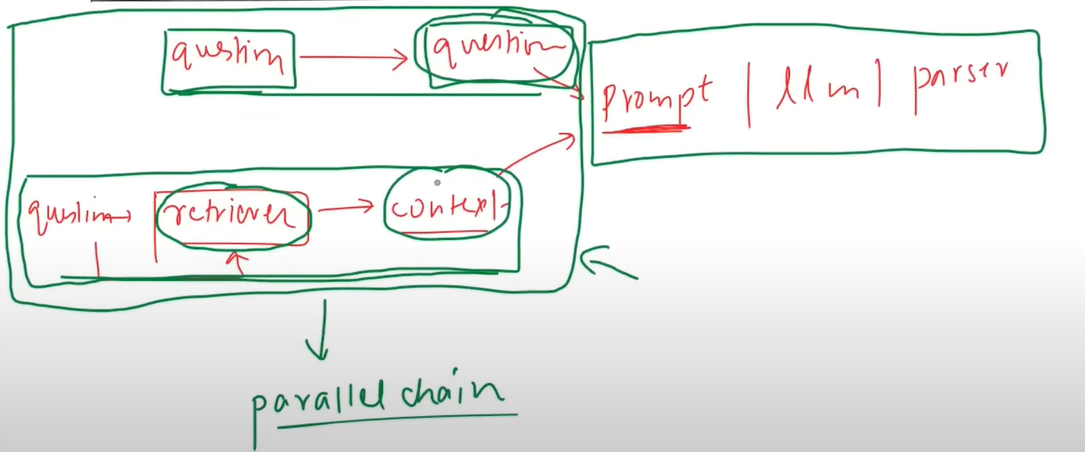

In [24]:
from langchain_core.runnables import RunnableParallel, RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser

In [25]:
def format_docs(retrieved_docs):
  context_text = "\n\n".join(doc.page_content for doc in retrieved_docs)
  return context_text

In [26]:
parallel_chain = RunnableParallel({
    'context': retriever | RunnableLambda(format_docs),
    'question': RunnablePassthrough()
})

In [27]:
parallel_chain.invoke('who is ben shapiro?')

{'context': "Shapiro presents himself as a moral authority on Israel Gaza while consistently avoiding nuance, dehumanizing Palestinians, and hiding behind a mask of so-called objective analysis. This interview cuts right through it. What to expect? a masterclass in journalism, Shapiro tripping over his own claims, and a painfully clear picture of how his ideology clashes with reality. Like, if you think arrogance without substance should be exposed, comment with your take on the Israel Palestine debate and subscribe for more videos where fake authority isn't enough. Uh, Ben Shapiro, you're followed by millions of people online and on social media. You're one of the biggest names in American conservatism. What is it you think you're tapping into? Well, I think that there there are a couple of things. One, there is actually a hunger for different ideas. The the monolithic nature of the United States media is pretty evident in terms of its politics. People tend to agree on essentially the

In [30]:
parser = StrOutputParser()
main_chain = parallel_chain | prompt | llm | parser
result = main_chain.invoke("What is the main view of Ben Shapiro on the topic? Tell me in 3 consice bullets.")

In [31]:
print(result)

- Ben Shapiro believes that the Palestinian population is largely responsible for electing Hamas and supporting anti-Israel sentiments, which he views as indicative of their broader attitudes.
- He presents himself as a moral authority on the Israel-Gaza conflict, advocating for a strong pro-Israel stance while dismissing criticisms as out of context or motivated by ulterior motives.
- Shapiro expresses frustration with interviews that challenge his views, perceiving them as attempts to undermine his arguments rather than engage in constructive debate.
